# Домашняя работа №1 по AB-тестам

<details>
  <summary>📝 Формулировка задания </summary>

!!!  Все считаем на 1000 итерациях

### Дизайн теста бутстреп
1. Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)
2. Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (2 балла)
3. На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (3 балла за расчет + 2 балла за подроброе объяснение)
4. Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (3 балла)


### Дизайн продолжение

1. Посчитать аналогичный дизайн для:
  - бутстреп + логарифмированная метрика длительности просмотров (4 балла)
  - манна-уитни + метрика длительности просмотров (4 балла)
  - манна-уитни + логарифмированная метрика длительности просмотров (4 балла)
  - t-test + метрика длительности просмотров (4 балла)
  - t-test + логарифмированная метрика длительности просмотров (4 балла)
2. Подробно описать выводы для каждой пары, какие варианты точно не подходят и почему. Объяснить зачем мы логарифмируем метрику и что нам это дает. Аргументированно выбрать 1 пару (метрика + критерий) которым вы будете оценивать АБ тест и какой эффект мы сможем отловить в нашем тесте. (5 баллов)


### A/B тест
1) Представим что у нас прошел тест, используем те же самые данные за 2 недели
2) Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (2 балла)
3) Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (1 балла)
4) Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (2 балла)
5) Посчитайте результат такого теста и сделайте выводы (10 баллов)

</details>



In [3]:
# Импорты необходимых библиотек
import os
import requests
import zipfile

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from tqdm import tqdm
from base64 import b64encode
import collections
import hashlib

from joblib import Memory, Parallel, delayed
from scipy.stats import norm, kstest, uniform
from scipy.stats import ttest_ind, mannwhitneyu
import scipy.stats

### Загрузка данных

In [4]:
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"
req = requests.get(url, stream=True)

with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

# Распаковываем архив из 3 файлов
with zipfile.ZipFile('data_kion.zip', 'r') as zip_ref:
    zip_ref.extractall()

kion dataset download:   9%|▉         | 7.34M/78.8M [00:03<00:37, 1.91MiB/s]


KeyboardInterrupt: 

### 📺 Данные: датасет КИОН
- **просмотры** фильмов и сериалов в приложении KION
- данные о пользователях
- данные об айтемах (фильмы, сериалы и т.д.)

In [3]:
interactions = pd.read_csv('data_kion/interactions_df.csv')
users = pd.read_csv('data_kion/users.csv')
items = pd.read_csv('data_kion/items.csv')

In [4]:
# взаимодействия между пользователе и контентом
display(interactions.head(5))
print('interactions: ', interactions.shape)

# user_id - уникальный идентификатор пользователя
# item_id - уникальный идентификатор контента
# last_watch_dt - последняя дата просмотра юзером определенного контента
# total_dur - суммарная продолжительность просмотра определенного контента юзером (в секундах)
# watched_pct - процент просмотренного контента от общей продолжительности

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


interactions:  (5476251, 5)


In [5]:
# пользователи
display(users.head())
print('users: ', users.shape)

# user_id - уникальный идентификатор пользователя
# kids_flg = 0 - детей нет, если 1 - дети есть
# income - группа, в которую юзер отнесен по доходу
# age - группа, в которую юзер отнесен по возрасту
# sex - пол

users.groupby('age', as_index=False).count()[['age', 'user_id']]

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


users:  (840197, 5)


,age,user_id
0,age_18_24,127672
1,age_25_34,233926
2,age_35_44,207043
3,age_45_54,135925
4,age_55_64,75265
5,age_65_inf,46271


In [6]:
# данные контента
display(items.head(3))
print('items: ', items.shape)

# item_id — уникальный идентификатор элемента (например, фильма, сериала или другого контента).
# content_type — тип контента: например, “film” для фильмов или другие типы.
# title — название контента, указанное на языке данных.
# title_orig — оригинальное название контента (если отличается от локального).
# release_year — год выпуска контента.
# genres — жанры, к которым относится контент (например, “драмы”, “комедии”).
# countries — страны, где был создан контент.
# for_kids — флаг, указывающий, является ли контент детским: 1 — да, 0 — нет.
# age_rating — возрастной рейтинг контента (например, 16+).
# studios — студии, которые создавали контент.
# directors — режиссёры, участвовавшие в создании контента.
# actors — актёры, задействованные в съёмках.
# description — описание контента (короткая аннотация, сюжет).
# keywords — ключевые слова, связанные с контентом (используются для поиска или рекомендаций).

items.groupby('content_type', as_index=False).count()[['content_type', 'item_id']]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."


items:  (15963, 14)


,content_type,item_id
0,film,12002
1,series,3961


In [7]:
# Функции из семинара, которые предполагаются в решении:
def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result

def salt_generator(salt=None):
    import os
    from base64 import b64encode
    salt = os.urandom(8)
    return b64encode(salt).decode('ascii')

def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))


def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

# Делим на 2 равные группы
def groups_splitter(df, columns, user_salt=None):

    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())
    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()


В этом ноутбуке представлено решение задач из домашнего задания по A/B тестам. 
Каждый раздел посвящён отдельному пункту задания и включает код с объяснениями.


## 🧪 Блок 1: Дизайн теста бутстреп

<details>
  <summary>📝 Формулировка задания для блока </summary>

1. Из `interactions` взять данные за 2 последние недели (**2021-08-09 по 2021-08-22**).
2. Посчитайте на этих данных **корректность на бутстрепе** и сравните её с результатами за 1 неделю (посчитано на семинаре).  
   **(2 балла)**
3. На двух неделях посчитайте **мощность**. Для этого нужно в одну из групп докинуть эффект:  
   - Докиньте эффект в **1%**, **3%** и **5%**.  
   - Сравните полученную мощность.  
   **(3 балла за расчет + 2 балла за подробное объяснение)**.
4. Посчитайте **MDE** (минимальный детектируемый эффект), который можно зафиксировать на 2-х неделях.  
   - В качестве **alpha** и **beta** подставьте ваши вычисленные ошибки 1 и 2 рода.  
   - Учитывайте, что у нас формула для MDE работает для **t-test** или **z-test**.  
   **(3 балла)**.

</details>

### 1.1 Предобработка и анализ данных
<details>
  <summary>📝 Формулировка задания </summary>

1. Из `interactions` взять данные за 2 последние недели (**2021-08-09 по 2021-08-22**).
</details>

In [8]:
# предобработка данных
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)

print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique():_}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique():_}")

display(interactions.head(5))

# Фильтрация данных за указанные даты
start_date, end_date = pd.to_datetime('2021-08-09').date(), pd.to_datetime('2021-08-22').date()
mid_date = pd.to_datetime('2021-08-15').date()

week_2 = interactions[(interactions['last_watch_dt'] >= start_date) & (interactions['last_watch_dt'] <= end_date)]
week_2 = week_2.groupby('user_id', as_index=False).agg({'total_dur': 'sum'})

print('Выборка за 2 недели:')
display(week_2.head(5))

Уникальных юзеров в interactions: 962_179
Уникальных айтемов в interactions: 15_706


,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


Выборка за 2 недели:


,user_id,total_dur
0,1,21172
1,1000,10744
2,1000000,32990
3,1000001,52
4,1000003,625


In [9]:
print(week_2.shape)
week_2 = week_2[(week_2['total_dur'] < week_2['total_dur'].std() * 3)]
print(week_2.shape)

(266081, 2)
(262794, 2)


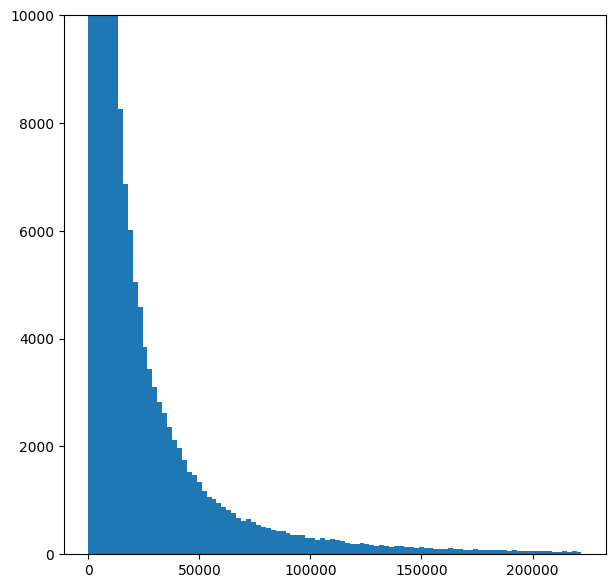

In [10]:
week_2['total_dur'].hist(bins=100, figsize=(7,7))
plt.ylim([0, 10000])
plt.grid(False)

<details>
  <summary> Вывод по графику </summary>    
Данные явно не соответствуют нормальному распределению: большинство пользователей имеют небольшую продолжительность просмотров, а распределение сильно скошено влево.

Что это означает? Это указывает на то, что наиболее распространенные статистические критерии, такие как t-test и z-test, не подходят для анализа нашей метрики "длина просмотра", так как они предполагают нормальность распределения.
</details>

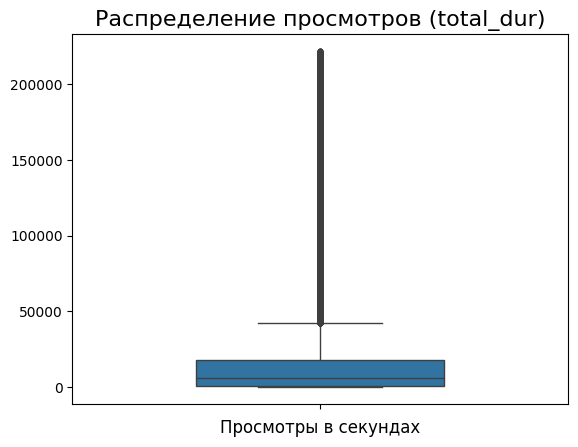

Максимальное значение просмотров (в секундах): 222029
Стандартное отклонение: 27843.53
Среднее значение просмотров: 15843.01
Медиана просмотров: 5602.0


In [11]:
# Поиск аномалий в данных
sns.boxplot(
    data=week_2['total_dur'].values,
    fliersize=3,
    width=0.5
)

plt.title('Распределение просмотров (total_dur)', fontsize=16)
plt.xlabel('Просмотры в секундах', fontsize=12)
plt.show()

# Статистическая информация о данных
print('Максимальное значение просмотров (в секундах):', week_2['total_dur'].max())
print('Стандартное отклонение:', round(week_2['total_dur'].std(), 2))
print('Среднее значение просмотров:', round(week_2['total_dur'].mean(), 2))
print('Медиана просмотров:', round(week_2['total_dur'].median(), 2))

### 1.2 Корректность на бутстрепе 
<details>
  <summary>📝 Формулировка задания </summary>

2. Посчитайте на этих данных **корректность на бутстрепе** и сравните её с результатами за 1 неделю (посчитано на семинаре).  
   **(2 балла)**

</details>

In [12]:
# Инициализация кэша
memory = Memory('./cache', verbose=0)

def calculate_iteration(week):
    """
    Выполняет одну итерацию расчёта и возвращает correctness и diff.
    """
    new_df = groups_splitter(week.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    vec_a = new_df[new_df['group'] == 'A']['total_dur']
    vec_b = new_df[new_df['group'] == 'B']['total_dur']

    # Bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    diff = sample_a_mean - sample_b_mean

    left_side, right_side = np.percentile(diff, [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних
    correctness = not (left_side <= 0 <= right_side)

    return correctness, diff

@memory.cache
def calculate_all_iterations_parallel(week, iterations, n_jobs=-1):
    """
    Выполняет итерации с использованием параллельных вычислений.
    """
    results = Parallel(n_jobs=n_jobs)(
        delayed(calculate_iteration)(week) for _ in range(iterations)
    )
    correctness_res, values_res = zip(*results)  # Разделяем результаты на два списка
    return list(correctness_res), list(values_res)

def calculate_correctness_with_cache(data_id, week, iterations=100, n_jobs=-1):
    """
    Рассчитывает корректность и разности средних с параллельным выполнением и кэшированием.
    """
    correctness, values = calculate_all_iterations_parallel(week, iterations, n_jobs=n_jobs)

    test_correctness = collections.Counter(correctness)
    res = test_correctness[1] / (test_correctness[1] + test_correctness[0]) * 100

    print(f"Корректность для {data_id}: {res}%")
    return res, values

In [13]:
# Данные по 1 неделе
week = interactions[(interactions['last_watch_dt'] >= start_date) & (interactions['last_watch_dt'] <= mid_date)]
week = week.groupby('user_id', as_index=False).agg({'total_dur': 'sum'})
week = week[(week['total_dur'] < week['total_dur'].std() * 3)]

In [14]:
week

,user_id,total_dur
0,1,19579
1,1000,10744
2,1000000,32990
3,1000009,1385
4,100001,65440
...,...,...
160789,999977,4570
160790,999978,482
160791,999989,4563
160792,999990,997


In [15]:
# Пример вызова для одной недели
res_week, diffs_week = calculate_correctness_with_cache(
        data_id="week_1",
        week=week,
        iterations=1000,    # Увеличиваем количество итераций до 1000
        n_jobs=-1           # Используем все доступные ядра
)

Корректность для week_1: 5.1%


In [16]:
# Пример вызова для двух недель
res_week_2, diffs_week_2 = calculate_correctness_with_cache(
        data_id="week_2",
        week=week_2,
        iterations=1000, 
        n_jobs=-1           
)

/Users/anastasia/docs/ITMO/AB/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Корректность для week_2: 4.8%


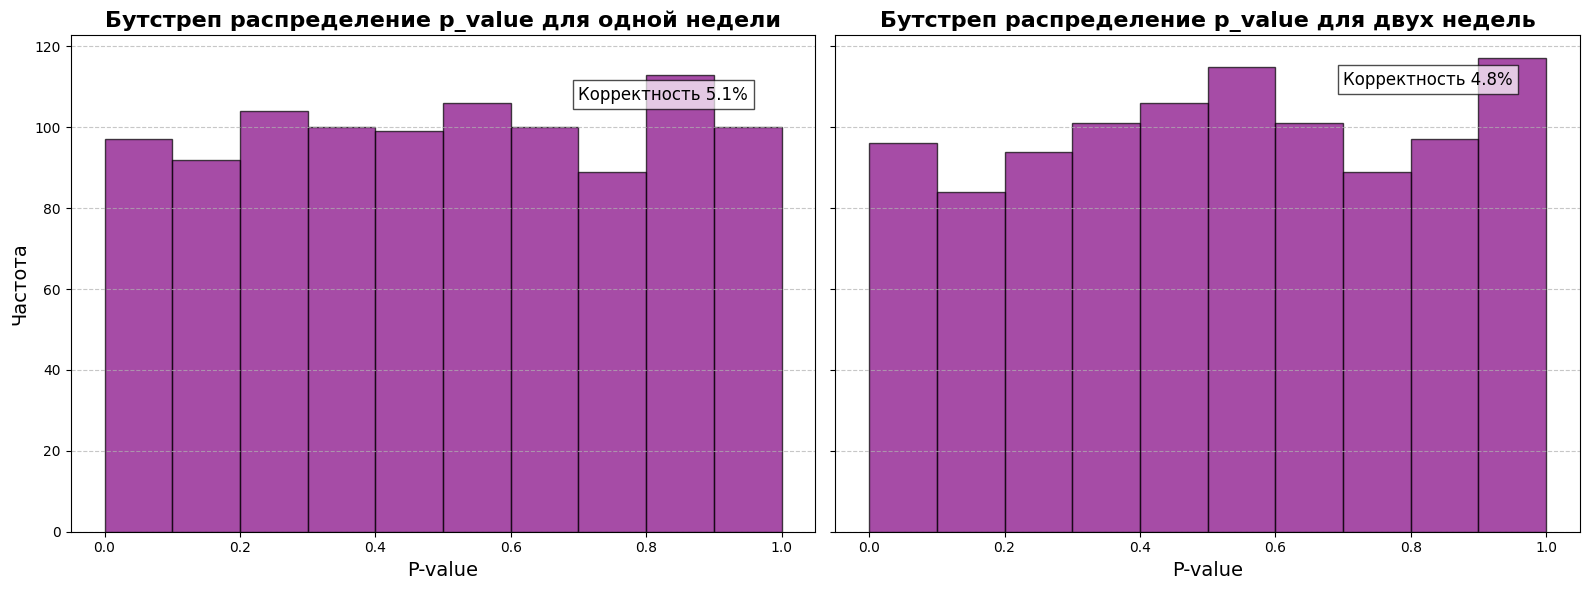

In [17]:
# Визуализация сравнения

# Данные для графиков
p_values_1 = [get_p_value(dist) for dist in diffs_week]
p_values_2 = [get_p_value(dist) for dist in diffs_week_2]

# Создание общего полотна
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# График для 1 недели
axes[0].hist(p_values_1, bins=10, color='purple', edgecolor='black', alpha=0.7)
axes[0].set_title("Бутстреп распределение p_value для одной недели", fontsize=16, fontweight='bold')
axes[0].set_xlabel("P-value", fontsize=14)
axes[0].set_ylabel("Частота", fontsize=14)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].text(0.7, max(axes[0].get_ylim()) * 0.9, f"Корректность {res_week}%", fontsize=12, color='black', 
             bbox=dict(facecolor='white', edgecolor='black', alpha=0.7))

# График для 2 недель
axes[1].hist(p_values_2, bins=10, color='purple', edgecolor='black', alpha=0.7)
axes[1].set_title("Бутстреп распределение p_value для двух недель", fontsize=16, fontweight='bold')
axes[1].set_xlabel("P-value", fontsize=14)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].text(0.7, max(axes[1].get_ylim()) * 0.9, f"Корректность {res_week_2}%", fontsize=12, color='black', 
             bbox=dict(facecolor='white', edgecolor='black', alpha=0.7))

plt.tight_layout()
plt.show()

<details>
  <summary> Вывод по сравнению корректности  </summary>

- Показатели корректности  находятся в пределах ожидаемых отклонений от уровня alpha. 
- В случае двух недель корректность меньше и  ближе к 5%. Учитывая, что был проведен A/A тест - это хорошо.

</details>

### 1.3 Мощность с эффектом **1%**, **3%** и **5%**
<details>
  <summary>📝 Формулировка задания </summary>

3. На двух неделях посчитайте **мощность**. Для этого нужно в одну из групп докинуть эффект:  
   - Докиньте эффект в **1%**, **3%** и **5%**.  
   - Сравните полученную мощность.  
   **(3 балла за расчет + 2 балла за подробное объяснение)**.

</details>


In [19]:
def calculate_power_iteration(week, effect_size):
    """
    Выполняет одну итерацию расчёта мощности с указанным эффектом.
    """
    new_df = groups_splitter(week.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    vec_a = new_df[new_df['group'] == 'A']['total_dur']
    vec_b = new_df[new_df['group'] == 'B']['total_dur'] * (1 + effect_size)  # Добавляем эффект

    # Bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    diff = sample_a_mean - sample_b_mean

    left_side, right_side = np.percentile(diff, [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])  # 95% доверительный интервал
    is_significant = not (left_side <= 0 <= right_side)

    return is_significant, diff

@memory.cache
def calculate_power_parallel(week, effect_size, iterations, n_jobs=-1):
    """
    Выполняет итерации с использованием параллельных вычислений.
    """
    results = Parallel(n_jobs=n_jobs)(
        delayed(calculate_power_iteration)(week, effect_size) for _ in range(iterations)
    )
    power_results, values_results = zip(*results)  # Разделяем результаты на два списка
    return list(power_results), list(values_results)

def calculate_power_with_cache(week, effect_size, iterations=1000, n_jobs=-1):
    """
    Рассчитывает мощность теста с параллельным выполнением и кэшированием.
    """
    power_results, values = calculate_power_parallel(week, effect_size, iterations, n_jobs=n_jobs)

    test_power = collections.Counter(power_results)
    power = test_power[1] / (test_power[1] + test_power[0]) * 100

    print(f"Мощность при эффекте {effect_size * 100}%: {power}%")
    return power, values

In [20]:
# Пример запуска для расщета мошности на разных эффектах
# Эффект 1%
power_1, diffs_1 = calculate_power_with_cache(
    week=week_2,
    effect_size=0.01,   # Эффект в 1%
    iterations=1000,    # Количество итераций
    n_jobs=8            # Количество ядер
)

/Users/anastasia/docs/ITMO/AB/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Мощность при эффекте 1.0%: 28.7%


In [21]:
# Эффект 3%
power_3, diffs_3 = calculate_power_with_cache(
    week=week_2,
    effect_size=0.03,   # Эффект в 3%
    iterations=1000,    # Количество итераций
    n_jobs=8            # Количество ядер
)

Мощность при эффекте 3.0%: 99.5%


In [22]:
# Эффект 5%
power_5, diffs_5 = calculate_power_with_cache(
    week=week_2,
    effect_size=0.05,   # Эффект в 5%
    iterations=1000,    # Количество итераций
    n_jobs=8            # Количество ядер
)

Мощность при эффекте 5.0%: 100.0%


In [23]:
md_content = f"""
<details>
  <summary> Вывод  </summary>
  
При эффекте 1% - Мощность составила {power_1}%.
- Низкая мощность теста при таком небольшом эффекте свидетельствует о том, что тест в большинстве случаев не сможет выявить изменения этой величины. Это указывает на недостаточную чувствительность текущей выборки для обнаружения слабых эффектов.     

При эффекте 3% - Мощность составила {power_3}%.
- Значительное увеличение мощности при эффекте 3% означает, что тест практически всегда фиксирует такие изменения. Это демонстрирует, что текущая выборка данных обладает достаточной чувствительностью для выявления умеренных эффектов.

При эффекте 5% - Мощность составила {power_5}%.
- Максимально возможное значение мощности. При таком эффекте вероятность ошибки второго рода практически отсутствует.

</details>
"""
display(Markdown(md_content))


<details>
  <summary> Вывод  </summary>
  
При эффекте 1% - Мощность составила 28.7%.
- Низкая мощность теста при таком небольшом эффекте свидетельствует о том, что тест в большинстве случаев не сможет выявить изменения этой величины. Это указывает на недостаточную чувствительность текущей выборки для обнаружения слабых эффектов.     

При эффекте 3% - Мощность составила 99.5%.
- Значительное увеличение мощности при эффекте 3% означает, что тест практически всегда фиксирует такие изменения. Это демонстрирует, что текущая выборка данных обладает достаточной чувствительностью для выявления умеренных эффектов.

При эффекте 5% - Мощность составила 100.0%.
- Максимально возможное значение мощности. При таком эффекте вероятность ошибки второго рода практически отсутствует.

</details>


### MDE
<details>
  <summary>📝 Формулировка задания </summary>

4. Посчитайте **MDE** (минимальный детектируемый эффект), который можно зафиксировать на 2-х неделях.  
   - В качестве **alpha** и **beta** подставьте ваши вычисленные ошибки 1 и 2 рода.  
   - Учитывайте, что у нас формула для MDE работает для **t-test** или **z-test**.  
   **(3 балла)**.
</details>

In [24]:
# Функция MDE
def get_mde(metric_vec, alpha=0.05, beta=0.2):

    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()

    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)

    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)

    return mde*100/metric_mean

# Вариант 1. подставление, полученных альфа и бета = (1 - мощность)
# в обсуждениях писали, что для бутстрепа такой вариант не подходит (поэтому Вариант 2.)
print(f'MDE (alpha = {res_week_2/100}, beta = {round(1-power_1/100, 3)}): {get_mde(week_2["total_dur"], alpha=res_week_2/100, beta=(round(1-power_1/100, 3)))}')
print(f'MDE (alpha = {res_week_2/100}, beta = {round(1-power_3/100, 3)}): {get_mde(week_2["total_dur"], alpha=res_week_2/100, beta=(round(1-power_3/100, 3)))}')
print(f'MDE (alpha = {res_week_2/100}, beta = {round(1-power_5/100, 3)}): {get_mde(week_2["total_dur"], alpha=res_week_2/100, beta=(round(1-power_5/100, 3)))}')

print('_' * 60)

# Вариант 2. Фиксированные значения
print(f'MDE (alpha = 0.05, beta = 0.1): {get_mde(week_2["total_dur"], alpha=0.05, beta=0.1)}')
print(f'MDE (alpha = 0.05, beta = 0.2): {get_mde(week_2["total_dur"], alpha=0.05, beta=0.2)}')
print(f'MDE (alpha = 0.05, beta = 0.3): {get_mde(week_2["total_dur"], alpha=0.05, beta=0.3)}')

MDE (alpha = 0.048, beta = 0.713): 0.4851723395904514
MDE (alpha = 0.048, beta = 0.005): 1.5609726582062105
MDE (alpha = 0.048, beta = 0.0): inf
____________________________________________________________
MDE (alpha = 0.05, beta = 0.1): 1.1112886904889456
MDE (alpha = 0.05, beta = 0.2): 0.9604673863892587
MDE (alpha = 0.05, beta = 0.3): 0.8517146150269004


<details>
  <summary>Вывод по варианту 2</summary>

Тест способен обнаружить изменения метрики, превышающие **1%**. 

- При уменьшении мощности теста (1-beta) MDE снижается:
  - 1.11% при beta=0.1,
  - 0.96% при beta=0.2,
  - 0.85% при beta=0.3.

Это показывает, что тест становится более чувствительным при меньшей мощности, но вероятность пропуска эффекта увеличивается. Текущий тест подходит для выявления эффектов средней и высокой величины (> 1%).
</details>

## 🔍 Блок 2: Дизайн продолжение

<details>
  <summary>📝 Формулировка задания</summary>

1. Рассчитать **аналогичный дизайн** для следующих комбинаций:  
   - **Бутстреп** + логарифмированная метрика длительности просмотров (**4 балла**).  
   - **Манна-Уитни** + метрика длительности просмотров (**4 балла**).  
   - **Манна-Уитни** + логарифмированная метрика длительности просмотров (**4 балла**).  
   - **t-test** + метрика длительности просмотров (**4 балла**).  
   - **t-test** + логарифмированная метрика длительности просмотров (**4 балла**).  

2. Подробно **описать выводы** для каждой пары:  
   - Какие варианты **точно не подходят** и почему?  
   - Объяснить, зачем **логарифмируем метрику** и какую пользу это даёт.  
   - Аргументированно выбрать **одну пару (метрика + критерий)**, которая будет использоваться для оценки A/B теста, а также объяснить, **какой эффект** можно будет отловить в этом тесте.  
   **(5 баллов)**

</details>

### Анализ предложенных дизайнов для А/Б теста

Рассмотрим каждую из комбинаций метрик и критериев для оценки длительности просмотров.

#### **1. Бутстреп + логарифмированная метрика длительности просмотров**
- **Выводы**: 
  Бутстреп хорошо подходит для анализа логарифмированной метрики, так как он не требует нормальности распределения. Логарифмирование уменьшает влияние выбросов, сглаживает длинные хвосты и делает распределение ближе к нормальному, что улучшает интерпретируемость результатов.
- **Плюсы**:
  - Работает с ненормальными распределениями.
  - Устойчив к выбросам.
  - Позволяет оценить доверительные интервалы для разницы между группами.
- **Минусы**:
  - Вычислительно затратен при большом объеме данных.
  - Требует настройки количества итераций.
- **Особенности**: Подходит для данных с сильной асимметрией и длинными хвостами.


#### **2. Манна-Уитни + метрика длительности просмотров**
- **Выводы**: 
  Непараметрический критерий Манна-Уитни сравнивает ранги, а не сами значения, что делает его устойчивым к выбросам и подходящим для исходной метрики с асимметричным распределением.
- **Плюсы**:
  - Не требует нормальности распределения.
  - Устойчив к выбросам.
- **Минусы**:
  - Менее мощный, чем параметрические тесты при нормальном распределении.
  - Потеря информации из-за использования рангов вместо значений.
- **Особенности**: Лучше использовать, если распределение данных сильно отличается от нормального.


#### **3. Манна-Уитни + логарифмированная метрика длительности просмотров**
- **Выводы**:
  Логарифмирование делает распределение более симметричным, что улучшает применение Манна-Уитни. Однако критерий по-прежнему сравнивает ранги, что может усложнить интерпретацию.
- **Плюсы**:
  - Работает с ненормальными распределениями.
  - Уменьшает влияние выбросов.
- **Минусы**:
  - Интерпретация результатов усложняется из-за логарифмирования.
  - Потеря информации из-за рангов.
- **Особенности**: Полезен для данных с выбросами, где важно уменьшить влияние аномальных значений.


#### **4. T-test + метрика длительности просмотров**
- **Выводы**: 
  T-test эффективен для нормальных распределений, но исходная метрика (длительность просмотров) обычно имеет длинный правый хвост, что нарушает его предположения.
- **Плюсы**:
  - Мощный тест при выполнении предположений.
  - Легкая интерпретация результатов.
- **Минусы**:
  - Требует нормальности распределения.
  - Чувствителен к выбросам.
- **Особенности**: Используется только при условии, что данные нормально распределены.


#### **5. T-test + логарифмированная метрика длительности просмотров**
- **Выводы**: 
  Логарифмирование может устранить длинные хвосты и привести распределение к нормальному, что делает применение t-test обоснованным.
- **Плюсы**:
  - Логарифмирование помогает выполнить предположения t-test.
  - Мощный тест при нормализованных данных.
- **Минусы**:
  - Интерпретация логарифмированных результатов сложнее.
  - Даже после логарифмирования распределение может оставаться неидеальным.
- **Особенности**: Подходит для метрик с распределением, близким к нормальному после логарифмирования.


### Зачем логарифмировать метрику?
- **Сглаживание выбросов**: Логарифмирование уменьшает влияние аномальных значений (например, супер большая длина просмотров total_dir), которые могут искажать результаты.
- **Уменьшение асимметрии**: Длинные хвосты распределения становятся короче, и данные становятся более симметричными.
- **Приближение к нормальному распределению**: Это важно для параметрических тестов, таких как t-test, которые требуют нормальности распределения.


### Вывод:
Для текущих данных, содержащих длительность просмотров с длинным хвостом и выбросами, наименее подходящим является **T-test + метрика длительности просмотров**. Это связано с тем, что данный тест требует нормального распределения данных, а исходная метрика имеет сильную асимметрию (слева) и выбросы, которые нарушают эти предположения. Кроме того, T-test чувствителен к выбросам, что делает его менее надежным в таких условиях.

Что касается остальных вариантов, то необходимо смотреть на результаты. Предположительно хорошо проявит себя **1. Бутстреп + логарифмированная метрика длительности просмотров**

### 2.1 Рассчет корректности для каждой комбинации
<details>
  <summary>Комбинации</summary>

   - **Бутстреп** + логарифмированная метрика длительности просмотров
   - **Манна-Уитни** + метрика длительности просмотров 
   - **Манна-Уитни** + логарифмированная метрика длительности просмотров 
   - **t-test** + метрика длительности просмотров 
   - **t-test** + логарифмированная метрика длительности просмотров 
</details>

In [25]:
# возьмем исходные данные (обзовем weeks_design ранее было week_2)
weeks_design = interactions[(interactions['last_watch_dt'] >= start_date) & (interactions['last_watch_dt'] <= end_date)]
weeks_design = weeks_design.groupby('user_id', as_index=False).agg({'total_dur': 'sum'})

# добавим логарифмирование как новый столбец в датасет
weeks_design['total_dur_log'] = np.log(1 + weeks_design['total_dur'])
display(weeks_design.head(5))

,user_id,total_dur,total_dur_log
0,1,21172,9.960482
1,1000,10744,9.282196
2,1000000,32990,10.403990
3,1000001,52,3.970292
4,1000003,625,6.439350


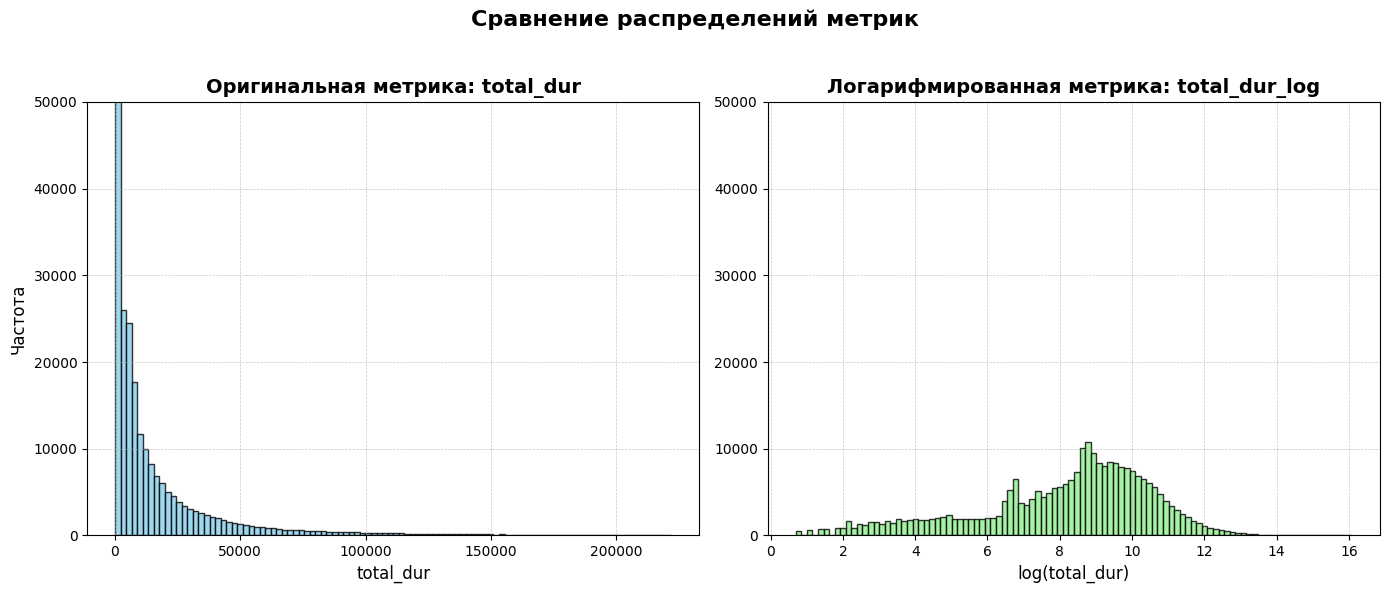

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), dpi=100)

# Оригинальная метрика
axs[0].hist(week_2['total_dur'], bins=100, color='skyblue', edgecolor='black', alpha=0.8)
axs[0].set_title("Оригинальная метрика: total_dur", fontsize=14, fontweight='bold')
axs[0].set_ylim([0, 50000])
axs[0].set_xlabel("total_dur", fontsize=12)
axs[0].set_ylabel("Частота", fontsize=12)
axs[0].grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

# Логарифмированная метрика
axs[1].hist(weeks_design['total_dur_log'], bins=100, color='lightgreen', edgecolor='black', alpha=0.8)
axs[1].set_title("Логарифмированная метрика: total_dur_log", fontsize=14, fontweight='bold')
axs[1].set_ylim([0, 50000])
axs[1].set_xlabel("log(total_dur)", fontsize=12)
axs[1].grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

# Общая настройка
plt.suptitle("Сравнение распределений метрик", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

In [29]:
weeks_design.drop(columns=['total_dur'], inplace=True)
weeks_design.rename(columns={'total_dur_log': 'total_dur'}, inplace=True)
weeks_design

,user_id,total_dur
0,1,9.960482
1,1000,9.282196
2,1000000,10.403990
3,1000001,3.970292
4,1000003,6.439350
...,...,...
266076,999978,9.321255
266077,999987,10.235988
266078,999989,8.425955
266079,999990,6.905753


Корректность для Бутстреп + логарифмированная метрика длительности просмотров: 5.1%
p_value = 0.25203015035214305 - p_values равномерное распределение


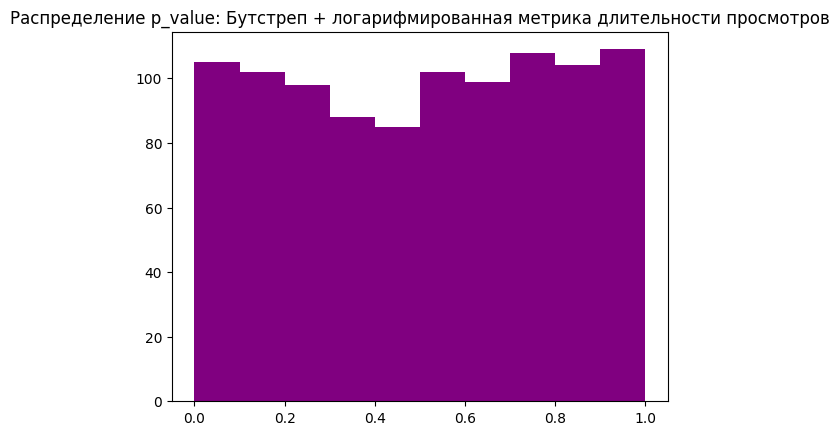

In [32]:
# Бутстреп + логарифмированная метрика длительности просмотров
sign_boot_log, diffs_boot_log = calculate_correctness_with_cache(
        data_id="Бутстреп + логарифмированная метрика длительности просмотров",
        week=weeks_design,
        iterations=1000,     # Увеличиваем количество итераций до 1000
        n_jobs=-1            # Используем 8 ядер, чтобы снизить нагрузку
)

# визуализация
p_values_boot_log = [get_p_value(dist) for dist in diffs_boot_log]

plt.hist(p_values_boot_log, bins=10, color='purple')
plt.title(f"Распределение p_value: Бутстреп + логарифмированная метрика длительности просмотров")

stat_boot_log, p_value_boot_log = scipy.stats.kstest(p_values_boot_log, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value_boot_log < 0.05:
    print(f'p_value = {p_value_boot_log} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value_boot_log} - p_values равномерное распределение')

100%|██████████| 1000/1000 [06:17<00:00,  2.65it/s]

p_value = 0.8198959913999354 - p_values равномерное распределение
Корректность = 0.042


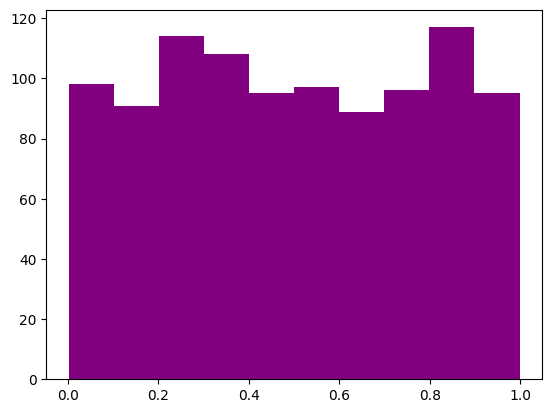

In [33]:
# Манна-Уитни + метрика длительности просмотров 
pvalues_man_ut = []

for i in tqdm(range(1000)):
    week_2_hash = groups_splitter(week_2, columns=['user_id', 'total_dur', 'group'])
    u, p = mannwhitneyu(
        week_2_hash[week_2_hash['group'] == 'A']['total_dur'].values,
        week_2_hash[week_2_hash['group'] == 'B']['total_dur'].values
    )
    pvalues_man_ut.append(p)

pvalues_man_ut = np.array(pvalues_man_ut)
plt.hist(pvalues_man_ut, bins=10, color='purple')

stat_man_ut, p_value_man_ut = scipy.stats.kstest(pvalues_man_ut, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value_man_ut < 0.05:
    print(f'p_value = {p_value_man_ut} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value_man_ut} - p_values равномерное распределение')

print(f"Корректность = {pvalues_man_ut[pvalues_man_ut < 0.05].shape[0] / pvalues_man_ut.shape[0]:.3f}")

100%|██████████| 1000/1000 [06:26<00:00,  2.59it/s]


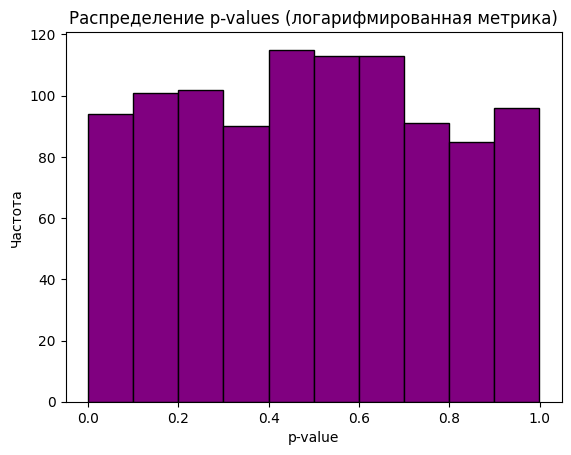

p_value = 0.28251206484396696 - p_values равномерное распределение
Корректность = 0.051


In [34]:
# Манна-Уитни + логарифмированная метрика длительности просмотров 
pvalues_man_ut_log = []

for i in tqdm(range(1000)):
    week_2_hash = groups_splitter(weeks_design, columns=['user_id', 'total_dur', 'group'])

    # Манна-Уитни тест
    u, p = mannwhitneyu(
        np.log(1 + week_2_hash[week_2_hash['group'] == 'A']['total_dur'].values),
        np.log(1 + week_2_hash[week_2_hash['group'] == 'B']['total_dur'].values)
    )
    pvalues_man_ut_log.append(p)

# Преобразование в массив
pvalues_man_ut_log = np.array(pvalues_man_ut_log)

# Построение гистограммы
plt.hist(pvalues_man_ut_log, bins=10, color='purple', edgecolor='black')
plt.title("Распределение p-values (логарифмированная метрика)")
plt.xlabel("p-value")
plt.ylabel("Частота")
plt.show()

# Проверка на равномерное распределение
stat_man_ut_log, p_value_man_ut_log = kstest(
    pvalues_man_ut_log, uniform(loc=0.0, scale=1.0).cdf
)

if p_value_man_ut_log < 0.05:
    print(f'p_value = {p_value_man_ut_log} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value_man_ut_log} - p_values равномерное распределение')

# Расчет корректности
correctness_log = pvalues_man_ut_log[pvalues_man_ut_log < 0.05].shape[0] / pvalues_man_ut_log.shape[0]
print(f"Корректность = {correctness_log:.3f}")

100%|██████████| 1000/1000 [06:08<00:00,  2.71it/s]


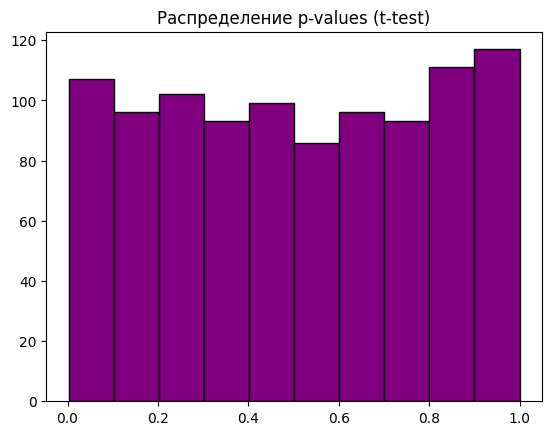

p_value = 0.32810297736867566 - p_values равномерное распределение
Корректность = 0.054


In [37]:
# t-test + метрика длительности просмотров 
p_values_tt = []

for i in tqdm(range(1000)):  # 1000
  two_weeks_hash = groups_splitter(week_2, columns=['user_id', 'total_dur', 'group'])

  u, p = ttest_ind(
        two_weeks_hash[two_weeks_hash['group'] == 'A']['total_dur'].values,
        two_weeks_hash[two_weeks_hash['group'] == 'B']['total_dur'].values
    )
  p_values_tt.append(p)

# Преобразуем в numpy массив
p_values_tt = np.array(p_values_tt)

# Построение гистограммы распределения p-values
plt.hist(p_values_tt, bins=10, color='purple', edgecolor='black')
plt.title("Распределение p-values (t-test)")
plt.show()

# Проверка равномерности распределения p-values
stat_tt, p_value_tt = kstest(p_values_tt, uniform(loc=0.0, scale=1.0).cdf)

if p_value_tt < 0.05:
    print(f'p_value = {p_value_tt} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value_tt} - p_values равномерное распределение')

# Расчет корректности
correctness_tt = p_values_tt[p_values_tt < 0.05].shape[0] / p_values_tt.shape[0]
print(f"Корректность = {correctness_tt:.3f}")

100%|██████████| 1000/1000 [06:06<00:00,  2.73it/s]


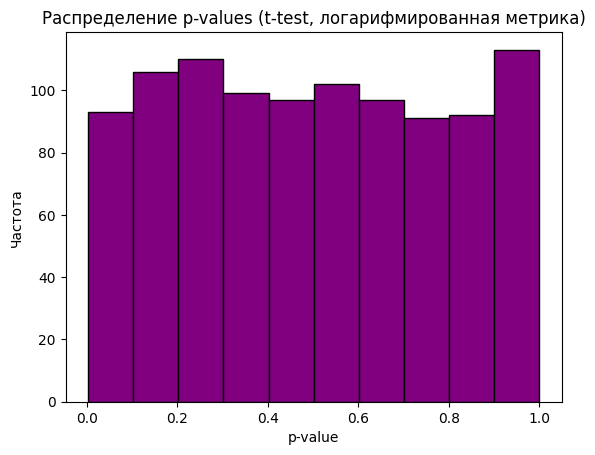

p_value = 0.8313550672358833 - p_values равномерное распределение
Корректность = 0.041


In [36]:
# t-test + логарифмированная метрика длительности просмотров 
p_values_tt_log = []

for i in tqdm(range(1000)):  # 1000 итераций
    # Разделение данных
    two_weeks_hash = groups_splitter(weeks_design, columns=['user_id', 'total_dur', 'group'])

    # t-test
    u, p = ttest_ind(
        np.log(1 + two_weeks_hash[two_weeks_hash['group'] == 'A']['total_dur'].values),
        np.log(1 + two_weeks_hash[two_weeks_hash['group'] == 'B']['total_dur'].values)
    )
    p_values_tt_log.append(p)

# Преобразуем в numpy массив
p_values_tt_log = np.array(p_values_tt_log)

# Построение гистограммы распределения p-values
plt.hist(p_values_tt_log, bins=10, color='purple', edgecolor='black')
plt.title("Распределение p-values (t-test, логарифмированная метрика)")
plt.xlabel("p-value")
plt.ylabel("Частота")
plt.show()

# Проверка равномерности распределения p-values
stat_tt_log, p_value_tt_log = kstest(p_values_tt_log, uniform(loc=0.0, scale=1.0).cdf)

if p_value_tt_log < 0.05:
    print(f'p_value = {p_value_tt_log} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value_tt_log} - p_values равномерное распределение')

# Расчет корректности
correctness_tt_log = p_values_tt_log[p_values_tt_log < 0.05].shape[0] / p_values_tt_log.shape[0]
print(f"Корректность = {correctness_tt_log:.3f}")

#### Вывод по расчету корректности
Наилучшую корректность проверки A/A теста показали комбинации (если считать альфа = 0.05):
- Манна-Уитни + метрика длительности просмотров: 0.042 
- t-test + логарифмированная метрика длительности просмотров: 0.041 

Соответственно, проведем дальнейшее вычисление мощности на этих комбинациях. (Логарифмирование не всегда сработывало хорошо, как ожидалось...)

### 2.2 Рассчет мощности для комбинаций
Будем докидывать эффект 1 % или 3%, эти значения оптимальны. (Например, в первом блоке исследований, было видно, что тест очень чувствителен к эффекту, выдавая при 3% уже мощность под 100%)

<details>
  <summary>Комбинации</summary>

   - **Манна-Уитни** + метрика длительности просмотров 
   - **t-test** + логарифмированная метрика длительности просмотров 
   
</details>

#### Расчет мощности для Манна-Уитни + метрика длительности просмотров

In [38]:
# манна-уитни + метрика длительности просмотров
effect = 0.01
p_values = []

for i in tqdm(range(1000)):
    week_2_hash = groups_splitter(week_2, columns=['user_id', 'total_dur', 'group'])
    
    u, p = mannwhitneyu(
        week_2_hash[week_2_hash['group'] == 'A']['total_dur'].values,
        week_2_hash[week_2_hash['group'] == 'B']['total_dur'].values * (1 + effect)
    )
    p_values.append(p)   

p_values = np.array(p_values)
power_1_m = p_values[p_values < 0.05].shape[0] / p_values.shape[0]
print(f"Мощность = {power_1_m:.3f}")

100%|██████████| 1000/1000 [06:26<00:00,  2.59it/s]

Мощность = 0.240


In [39]:
# манна-уитни + метрика длительности просмотров
effect = 0.03
p_values = []

for i in tqdm(range(1000)):
    week_2_hash = groups_splitter(week_2, columns=['user_id', 'total_dur', 'group'])
    
    u, p = mannwhitneyu(
        week_2_hash[week_2_hash['group'] == 'A']['total_dur'].values,
        week_2_hash[week_2_hash['group'] == 'B']['total_dur'].values * (1 + effect)
    )
    p_values.append(p)   

p_values = np.array(p_values)
power_3_m = p_values[p_values < 0.05].shape[0] / p_values.shape[0]
print(f"Мощность = {power_3_m:.3f}")

100%|██████████| 1000/1000 [06:27<00:00,  2.58it/s]

Мощность = 0.954


#### Расчет мощности для t-test + логарифмированная метрика длительности просмотров

In [40]:
# t-test + логарифмированная метрика длительности просмотров
effect = 0.01
p_values = []

for i in tqdm(range(1000)):

  two_weeks_hash = groups_splitter(week_2, columns=['user_id', 'total_dur', 'group'])

  u, p = ttest_ind(
        np.log(1 + two_weeks_hash[two_weeks_hash['group'] == 'A']['total_dur'].values),
        np.log(1 + two_weeks_hash[two_weeks_hash['group'] == 'B']['total_dur'].values  * (1+effect))
    )
  p_values.append(p)

p_values = np.array(p_values)
power_1_t = p_values[p_values < 0.05].shape[0] / p_values.shape[0]
print(f"Мощность = {power_1_t:.3f}")

100%|██████████| 1000/1000 [06:08<00:00,  2.71it/s]

Мощность = 0.187


In [41]:
# t-test + логарифмированная метрика длительности просмотров
effect = 0.03
p_values = []

for i in tqdm(range(1000)):

  two_weeks_hash = groups_splitter(week_2, columns=['user_id', 'total_dur', 'group'])

  u, p = ttest_ind(
        np.log(1 + two_weeks_hash[two_weeks_hash['group'] == 'A']['total_dur'].values),
        np.log(1 + two_weeks_hash[two_weeks_hash['group'] == 'B']['total_dur'].values  * (1+effect))
    )
  p_values.append(p)

p_values = np.array(p_values)
power_3_t = p_values[p_values < 0.05].shape[0] / p_values.shape[0]
print(f"Мощность = {power_3_t:.3f}")

100%|██████████| 1000/1000 [06:12<00:00,  2.69it/s]

Мощность = 0.882


#### Результаты 

Расчитанные мощности на 1000 итерациях с добавлением 1% эффекта:
- манна-уитни + метрика длительности просмотров: 0.240
- t-test + логарифмированная метрика длительности просмотров: 0.187

Расчитанные мощности на 1000 итерациях с добавлением 3% эффекта:
- манна-уитни + метрика длительности просмотров: 0.954
- t-test + логарифмированная метрика длительности просмотров: 0.882

Выбрана комбинация `манна-уитни + метрика длительности просмотров` поскольку показывает лучший результат на тестах.

In [42]:
# Расчет MDE для выбранной пары 
alpha_res = 0.042
beta_res = 0.954

print(f"MDE (alpha = {alpha_res}, beta = {1 - beta_res}): {get_mde(week_2['total_dur'], alpha=alpha_res, beta=1 - beta_res)}")

MDE (alpha = 0.042, beta = 0.04600000000000004): 1.2747998580843485


<details>
  <summary> Про MDE</summary>

При MDE = 1.2748, тест способен обнаружить минимальный эффект в размере 1.2748 единиц total_dur с вероятностью 95.4%, сохраняя уровень значимости 4.2%. Соответственно для эффекта 3$ он рабочий.

</details>

## 🎯 Блок 3:  A/B Тест

<details>
  <summary>📝 Формулировка задания</summary>

1. **Предположим, что тест уже прошёл**, используем те же самые данные за 2 недели.  
2. **Обнулите значения `total_dur`** для всех пользователей, у которых `total_dur < 500`.  
   - Эти значения принимаем за нулевые, но пользователей НЕ исключаем из эксперимента.  
   **(2 балла)**  
3. **Разбейте пользователей на две равные группы**:  
   - Используйте функцию `groups_splitter`.  
   - В качестве соли используйте `'kiontestmodel20210805'`.  
   **(1 балл)**  
4. **Добавьте эффект в группу B:**  
   - Модель в группе B показала результат на **2.5% лучше**, чем в группе A.  
   - Эффект распределён неравномерно, преимущественно на **10% самых активных пользователей**.  
   - Увеличьте метрику `total_dur` на **2.5%** для этих 10%.  
   **(2 балла)**  
5. **Рассчитайте результаты теста и сделайте выводы.**  
   **(10 баллов)**

</details>

,user_id,total_dur
0,1,21172
1,1000,10744
2,1000000,32990
3,1000001,0
4,1000003,625


<Axes: >

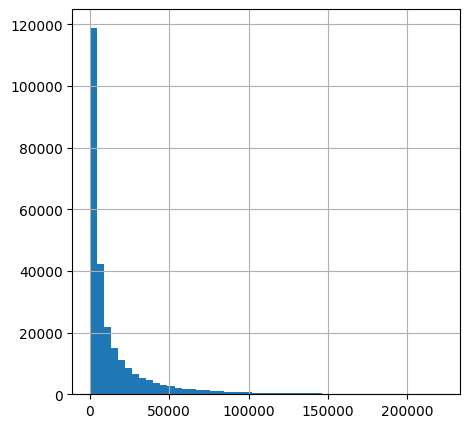

In [159]:
# 3.1 подтянем данные (чтобы работать на чистых)
weeks = interactions[(interactions['last_watch_dt'] >= start_date) & (interactions['last_watch_dt'] <= end_date)]
weeks = weeks.groupby('user_id', as_index=False).agg({'total_dur': 'sum'})
weeks = weeks[(weeks['total_dur'] < weeks['total_dur'].std() * 3)]

# 3.2 Обнуление значений total_dur для пользователей, где total_dur < 500
weeks['total_dur'] = weeks['total_dur'].where(weeks['total_dur'] >= 500, 0)
display(weeks.head(5))

# визуализация
weeks['total_dur'].hist(bins=50, figsize=(5,5))

In [160]:
# 3.3 Применение функции groups_splitter для разделения на группы
weeks_group = groups_splitter(weeks.copy(), columns=['user_id', 'total_dur', 'group'], user_salt='kiontestmodel20210805')
weeks_group

,user_id,total_dur,group
0,1,21172,B
1,1000,10744,B
2,1000000,32990,B
3,1000001,0,B
4,1000003,625,A
...,...,...,...
266076,999978,11172,A
266077,999987,27888,A
266078,999989,4563,B
266079,999990,997,B


In [161]:
# 3.4 Добавьте эффект в группу B

# Преобразуем total_dur в float64
weeks_group['total_dur'] = weeks_group['total_dur'].astype(float)

# Отбор группы B
group_b = weeks_group[weeks_group['group'] == "B"]

# Находим порог для 10% самых активных пользователей
top_10_percent_threshold = group_b['total_dur'].quantile(0.9)

# Увеличиваем метрику для этих пользователей
weeks_group.loc[(weeks_group['group'] == "B") & (weeks_group['total_dur'] >= top_10_percent_threshold), 'total_dur'] *= 1.025

# Разделяем данные по группам
group_a = weeks_group[weeks_group['group'] == "A"]['total_dur']
group_b = weeks_group[weeks_group['group'] == "B"]['total_dur']

In [171]:
# 3.5 Рассчитайте результаты теста и сделайте выводы

# t-test
_, p_value_t = ttest_ind(group_a, group_b)

# Mann-Whitney test
_, p_value_mw = mannwhitneyu(group_a, group_b)

print(f"T-test: p-value = {p_value_t}")
print(f"Mann-Whitney: p-value = {p_value_mw}")

# 2. Вычисление среднего значения и разницы
mean_a = group_a.mean()
mean_b = group_b.mean()
effect = (mean_b - mean_a) / mean_a * 100
print(f"Среднее группы A: {mean_a:.2f}")
print(f"Среднее группы B: {mean_b:.2f}")
print(f"Разница: {effect:.2f}%")

T-test: p-value = 0.033496527241656165
Mann-Whitney U Test: p-value = 0.09187290419766353
Среднее группы A: 15808.00
Среднее группы B: 16041.82
Разница: 1.48%


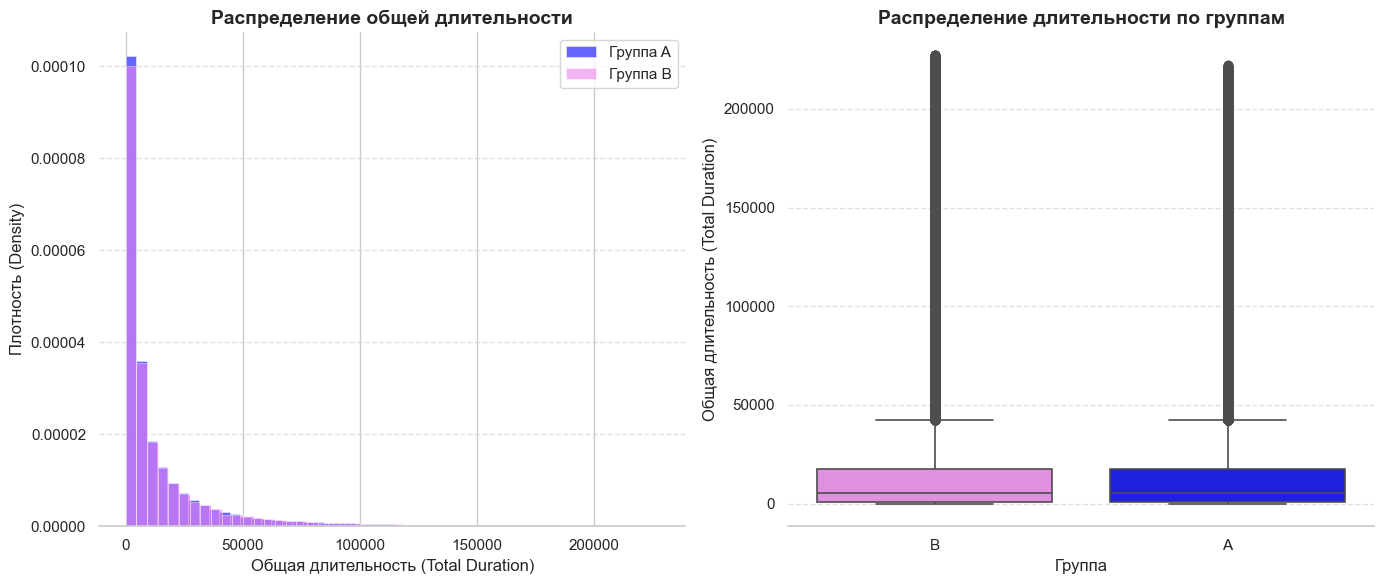

In [178]:
# Настройка стиля
sns.set_theme(style="whitegrid")

# Создание фигуры с двумя графиками рядом
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Увеличенный размер для красивого отображения

# Гистограмма
axes[0].hist(group_a, bins=50, alpha=0.6, label='Группа A', color='blue', density=True, edgecolor='white', linewidth=0.5)
axes[0].hist(group_b, bins=50, alpha=0.6, label='Группа B', color='violet', density=True, edgecolor='white', linewidth=0.5)
axes[0].set_title('Распределение общей длительности', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Общая длительность (Total Duration)', fontsize=12)
axes[0].set_ylabel('Плотность (Density)', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.6)
axes[0].legend(loc='upper right', fontsize=11)

# Boxplot
sns.boxplot(data=weeks_group, x='group', y='total_dur', ax=axes[1], palette={'A': 'blue', 'B': 'violet'}, linewidth=1.2, hue='group')
axes[1].set_title('Распределение длительности по группам', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Группа', fontsize=12)
axes[1].set_ylabel('Общая длительность (Total Duration)', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

# Удаление лишних рамок
sns.despine(left=True)

# Подгонка расстояний между графиками
plt.tight_layout()

# Отображение графиков
plt.show()

### Выводы

1. **Статистическая значимость**:  
   - T-test (\(p = 0.033\)) показал статистически значимую разницу между группами A и B на уровне значимости \(0.05\). Это подтверждает влияние изменений в группе B (увеличение на 2.5% для активных пользователей).  
   - Манна-Уитни (\(p = 0.092\)) значимость не подтвердил, возможно, из-за высокой вариативности данных.

2. **Практическая значимость**:  
   - Среднее значение `total_dur` в группе B на 1.48% выше, чем в группе A. Этот эффект может быть полезен, если его масштабировать на всех пользователей.

3. **Графический анализ**:  
   - Гистограмма показывает схожесть распределений, но группа B демонстрирует небольшое улучшение.  
   - Boxplot подчёркивает близость медианных значений и влияние выбросов.

4. **Рекомендации**:  
   - Масштабировать изменения для всех пользователей, если эффект в 1.48% важен для бизнеса.  
   - Провести дополнительные эксперименты, чтобы учесть вариативность данных и проверить их соответствие предположениям T-test.

**Общий вывод**:  
Эффект в группе B увеличил метрику `total_dur` на 1.48%. T-test подтверждает статистическую значимость, что делает эффект перспективным для масштабирования. Однако, для большей уверенности, рекомендуется провести дополнительные проверки и эксперименты.